In [117]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join
from hwtmode.data import load_patch_files, min_max_scale, storm_max_value, get_meta_scalars, combine_patch_data
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tensorflow as tf
%matplotlib inline

In [96]:
config_filename = "../config/ws_mode_cnn_train_20200430.yml"
with open(config_filename, "r") as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)

In [4]:

# Load training data
print(f"Loading training data period: {config['train_start_date']} to {config['train_end_date']}")
input = {}
output = {}
out_max = {}
labels = {}
meta = {}
meta_df = {}
input_combined = {}
input_scaled = {}
scale_values = {}
predictions = {}
modes = ["train", "val", "test"]
# Load training, validation, and testing data
for mode in modes:
    input[mode], output[mode], meta[mode] = load_patch_files(config[mode + "_start_date"],
                                                             config[mode + "_end_date"],
                                                             config["data_path"],
                                                             config["input_variables"],
                                                             config["output_variables"],
                                                             config["meta_variables"],
                                                             config["patch_radius"])
    input_combined[mode] = combine_patch_data(input[mode], config["input_variables"])
    if mode == "train":
        input_scaled[mode], scale_values[mode] = min_max_scale(input_combined[mode])
    else:
        input_scaled[mode], scale_values[mode] = min_max_scale(input_combined[mode], scale_values["train"])
    out_max[mode] = storm_max_value(output[mode][config["output_variables"][0]], meta[mode]["masks"])
    meta_df[mode] = get_meta_scalars(meta[mode])
    print(meta_df[mode].columns)
    if config["classifier"]:
        labels[mode] = np.where(out_max[mode] >= config["classifier_threshold"], 1, 0)
    else:
        labels[mode] = out_max[mode]

  0%|                               | 0/317 [00:00<?, ?it/s]

Loading training data period: 2010-10-01 to 2014-12-31


100%|█████████████████████| 317/317 [07:53<00:00,  1.49s/it]


REFL_1KM_AGL_curr
U10_curr
V10_curr


  0%|                                | 0/73 [00:00<?, ?it/s]

['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


100%|███████████████████████| 73/73 [01:48<00:00,  1.49s/it]


REFL_1KM_AGL_curr
U10_curr
V10_curr


  0%|                               | 0/180 [00:00<?, ?it/s]

['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


100%|█████████████████████| 180/180 [04:57<00:00,  1.65s/it]


REFL_1KM_AGL_curr
U10_curr
V10_curr
['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


(array([0.0655556 , 0.33209671, 0.57118392, 0.73284569, 0.83522842,
        0.89769173, 0.93563576, 0.95934475, 0.97432876, 0.98405676,
        0.98980334, 0.99359205, 0.99586527, 0.99744645, 0.9983794 ,
        0.99901888, 0.99938242, 0.99965398, 0.999781  , 0.99983356,
        0.99990802, 0.99994744, 0.9999781 , 0.99998686, 0.99998686,
        0.99998686, 0.99998686, 0.99998686, 0.99999124, 1.        ]),
 array([1.19316763e-04, 4.14707477e+00, 8.29403023e+00, 1.24409857e+01,
        1.65879411e+01, 2.07348966e+01, 2.48818520e+01, 2.90288075e+01,
        3.31757630e+01, 3.73227184e+01, 4.14696739e+01, 4.56166293e+01,
        4.97635848e+01, 5.39105402e+01, 5.80574957e+01, 6.22044511e+01,
        6.63514066e+01, 7.04983620e+01, 7.46453175e+01, 7.87922730e+01,
        8.29392284e+01, 8.70861839e+01, 9.12331393e+01, 9.53800948e+01,
        9.95270502e+01, 1.03674006e+02, 1.07820961e+02, 1.11967917e+02,
        1.16114872e+02, 1.20261828e+02, 1.24408783e+02]),
 <a list of 30 Patch objects

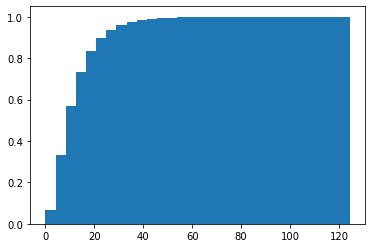

In [85]:
plt.hist(out_max["train"], 30, density=True, cumulative=True)


In [97]:
config["out_path"]

'/glade/work/dgagne/mode_cnn_20200430/'

In [26]:
input["val"]

<xarray.Dataset>
Dimensions:            (col: 33, p: 62865, row: 33)
Coordinates:
  * col                (col) int32 24 25 26 27 28 29 30 ... 50 51 52 53 54 55 56
  * row                (row) int32 24 25 26 27 28 29 30 ... 50 51 52 53 54 55 56
  * p                  (p) int64 0 1 2 3 4 5 ... 62860 62861 62862 62863 62864
Data variables:
    REFL_1KM_AGL_curr  (p, row, col) float32 -32.16125 -17.883072 ... 18.350441
    U10_curr           (p, row, col) float32 7.4909678 7.1230865 ... -2.4446685
    V10_curr           (p, row, col) float32 8.080585 8.206953 ... -0.49967128
Attributes:
    Conventions:             CF-1.6
    title:                   NCARSTORM Storm Patches for run 20140111-0000 me...
    object_variable:         REFL_COM
    start_hour:              12
    end_hour:                35
    watershed_variable:      REFL_COM
    ensemble_name:           NCARSTORM
    ensemble_members:        ['d01']
    model_path:              /glade/p/mmm/parc/sobash/NSC/3KM_WRF_POST_12sec_ts/
    segmentation_approach:   ws
    model_watershed_params:  (35, 50)
    size_filter:             12
    gaussian_window:         1
    mrms_path:               None
    mrms_variable:           MESH_Max_60min_00.50
    mrms_watershed_params:   (13, 1, 125, 100, 100)
    object_matcher_params:   ([<function shifted_centroid_distance at 0x2b026...
    track_matcher_params:    ([<function centroid_distance at 0x2b026d7c2950>...
    shape_variables:         ['area', 'eccentricity', 'major_axis_length', 'm...
    variable_statistics:     ['mean', 'max', 'min']
    csv_path:                /glade/scratch/ahijevyc/track_data_ncarstorm_3km...
    geojson_path:            /glade/scratch/ahijevyc/track_data_ncarstorm_3km...
    nc_path:                 /glade/scratch/ahijevyc/track_data_ncarstorm_3km...
    patch_radius:            40
    unique_matches:          True
    closest_matches:         True
    match_steps:             True
    train:                   False
    single_step:             True
    label_type:              gamma
    model_map_file:          /glade/u/home/sobash/hagelslag/mapfiles/ncar_sto...
    mask_file:               /glade/u/home/sobash/hagelslag/mapfiles/ncar_sto...
    json:                    False
    run_date_format:         %Y%m%d-%H%M

In [124]:
cnn_name = "cnn_20200430"
cnn_number = 3
mode = "train"
sal_ds = xr.open_dataarray(join(config["out_path"], f"neuron_saliency_{cnn_name}_{cnn_number:03d}_{mode}.nc"))
neuron_activations = pd.read_csv(join(config["out_path"], f"neuron_activations_{cnn_name}_{cnn_number:03d}_{mode}.csv"))
neuron_scores = pd.read_csv(join(config["out_path"], f"neuron_scores_{cnn_name}_{cnn_number:03d}.csv"))

In [94]:
neuron_scores

,mode,neuron_000,neuron_001,neuron_002,neuron_003,neuron_004,neuron_005,neuron_006,neuron_007,neuron_008
0,train,0.786557,0.784118,0.202558,0.689415,0.707626,0.787211,0.201894,0.794470,0.783216
1,val,0.789713,0.786852,0.198741,0.693690,0.708958,0.790466,0.198036,0.799725,0.785845
2,test,0.796696,0.793472,0.191661,0.695540,0.716999,0.797540,0.190961,0.804005,0.792382


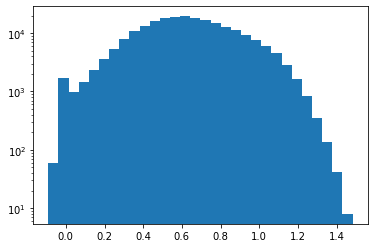

In [112]:
plt.hist(neuron_activations["neuron_003"], bins=30)
plt.gca().set_yscale("log")

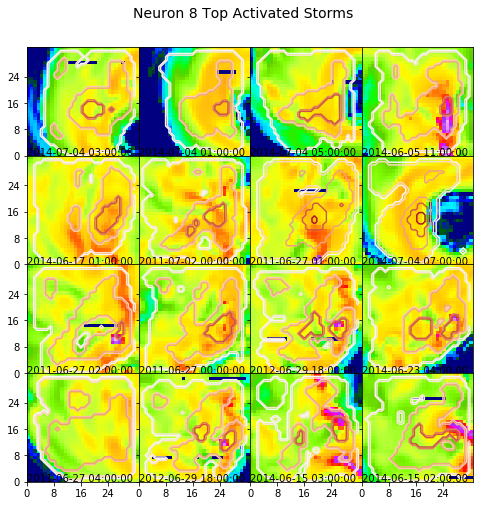

In [105]:
neuron_number = 8
n_rank = neuron_activations[f"neuron_{neuron_number:03d}"].argsort()[::-1].values
fig, axes = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
sal_ex = sal_ds[neuron_number, n_rank[:16], :, :, 0]
sal_max = np.abs(sal_ex).max()
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(input_combined[mode][n_rank[a], :, :, 0], cmap="gist_ncar", vmin=0, vmax=80)
    #gf = gaussian_filter(sal_ds[neuron_number, n_rank[a], :, :, 0], 1)
    #ax.contour(gf / gf.std(), [-3, -2, 2, 3], vmin=-3, vmax=3, cmap="RdBu_r")
    ax.contour(-sal_ex[a], 5, vmin=-sal_max, vmax=sal_max, cmap="RdBu_r")
    ax.set_xticks(np.arange(0, 32, 8))
    ax.set_yticks(np.arange(0, 32, 8))
    ax.text(0, 0, meta_df[mode].loc[n_rank[a], "time"])
fig.suptitle(f"Neuron {neuron_number} Top Activated Storms", fontsize=14, y=0.95)
plt.savefig(f"cnn_{cnn_number}_neuron_{neuron_number:03d}_{mode}.png", dpi=200, bbox_inches="tight")

In [103]:
meta_df["train"]

,time,centroid_lon,centroid_lat,centroid_i,centroid_j,track_id,track_step,run_date
p,,,,,,,,
0,2010-10-24 12:00:00,-98.462074,42.926563,660.0,758.0,0,1,2010-10-24
1,2010-10-24 12:00:00,-97.605072,43.014626,664.0,781.0,1,1,2010-10-24
2,2010-10-24 12:00:00,-95.158211,44.227085,712.0,844.0,2,1,2010-10-24
3,2010-10-24 12:00:00,-94.406555,44.542973,725.0,863.0,3,1,2010-10-24
4,2010-10-24 13:00:00,-94.203041,44.667934,730.0,868.0,3,2,2010-10-24
...,...,...,...,...,...,...,...,...
228305,2014-12-24 11:00:00,-81.401443,34.864479,426.0,1278.0,747,1,2014-12-23
228306,2014-12-24 11:00:00,-80.867035,34.961498,433.0,1293.0,748,1,2014-12-23
228307,2014-12-24 11:00:00,-80.825348,35.482147,452.0,1290.0,749,1,2014-12-23


In [72]:
sal_ex.max()

<xarray.DataArray 'saliency' ()>
array(-0.)
Coordinates:
    var_name  <U17 'REFL_1KM_AGL_curr'

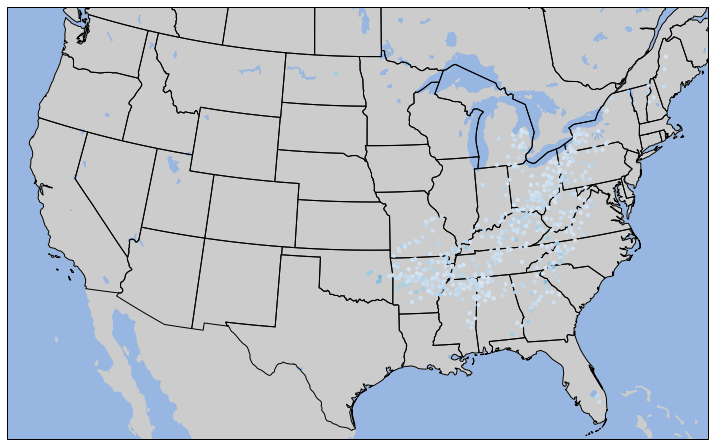

In [116]:
fig = plt.figure(figsize=(10, 6))
crs = ccrs.PlateCarree()
ax = fig.add_axes([0, 1, 1, 1], projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="0.8")
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
run_date = "2011-04-27 00:00:00"
n1_idx = (neuron_activations["run_date"] == run_date) & (neuron_activations["neuron_001"] > 1)
n3_idx = (neuron_activations["run_date"] == run_date) & (neuron_activations["neuron_003"] > 0.5)

n1_examples = np.where(n1_idx == True)[0]
ax.scatter(neuron_activations.loc[n1_idx, "centroid_lon"], 
            neuron_activations.loc[n1_idx, "centroid_lat"],
            10, neuron_activations.loc[n1_idx, "neuron_001"], vmin=0, vmax=3, cmap="Reds", transform=crs, zorder=4)
ax.scatter(neuron_activations.loc[n3_idx, "centroid_lon"], 
            neuron_activations.loc[n3_idx, "centroid_lat"],
            10, neuron_activations.loc[n3_idx, "neuron_003"], vmin=0, vmax=3, cmap="Blues", transform=crs, zorder=4)
ax.set_extent((-120, -74, 23, 50))

In [119]:
neuron_activations
tf.linalg.band_part()

TypeError: matrix_band_part() missing 3 required positional arguments: 'input', 'num_lower', and 'num_upper'

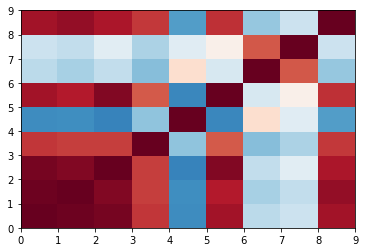

In [126]:
plt.pcolormesh(np.corrcoef(neuron_activations[[f"neuron_{x:03d}" for x in range(9)]].values.T), vmin=-1, vmax=1, cmap="RdBu_r")